In [1]:
%pip install torch
%pip install torchvision
%pip install opencv-python
%pip install cantools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 881.9/881.9 MB 3.0 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 35.2 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 MB 23.2 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 KB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.1/179.1 KB 11.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 KB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 KB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.5/132.5 KB 45.0 MB/s eta 0:00:00
  

In [3]:
import numpy as np
from dataset import RADIal
from loader import CreateDataLoaders
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import cv2
from torch.utils.data import Dataset, DataLoader, random_split,Subset
from IPython.display import clear_output, display
import matplotlib.animation as animation

In [4]:
# Load the camera calibration parameters
calib = np.load('../DBReader/examples/camera_calib.npy',allow_pickle=True).item()

In [5]:
dataset = RADIal(root_dir = '../dataset',difficult=True)

7297


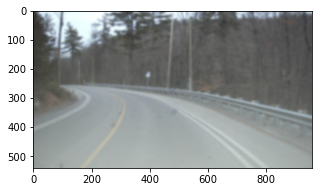

In [6]:
# pick-up randomly any sample
sample_number = np.random.randint(len(dataset));
print(sample_number)
data = dataset.__getitem__(sample_number)

image = data[0]
boxes = data[5]
fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(image)

## Camera

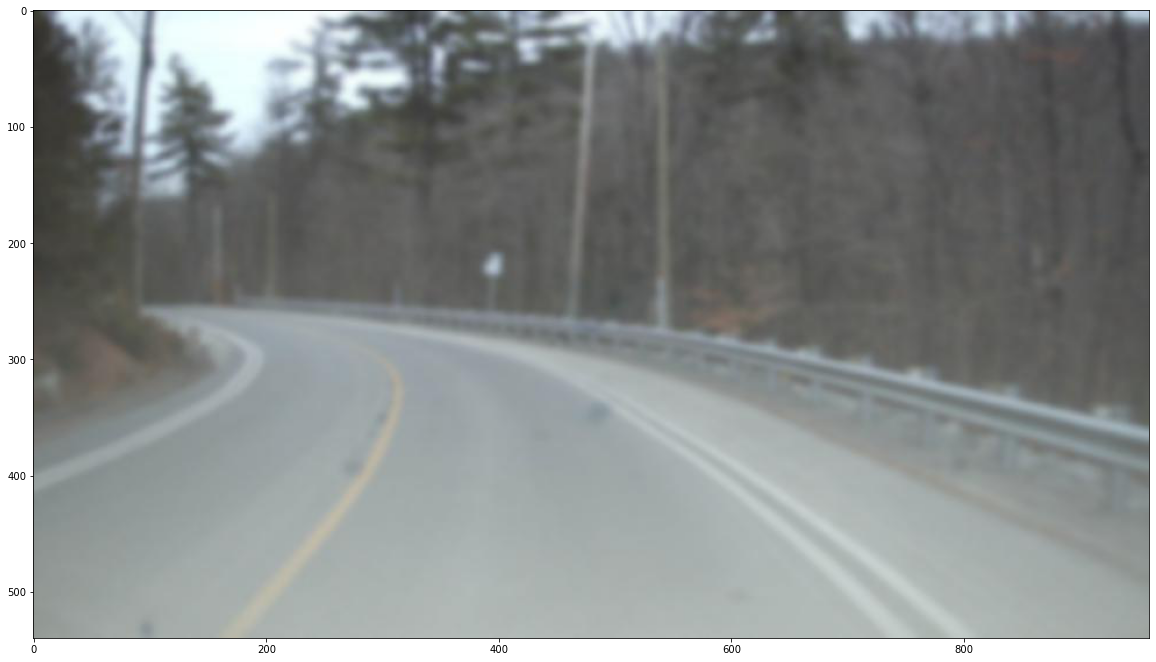

In [7]:
image = data[0]
boxes = data[5]

fig, ax = plt.subplots(figsize=(20,20))
ax.imshow(image)

for box in boxes:
    if(box[0]==-1):
        break # -1 means no object
    rect = Rectangle(box[:2]/2,(box[2]-box[0])/2,(box[3]-box[1])/2,linewidth=3, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    
# Note, coordinates are divided by 2 as image were saved in quarter resolution

In [8]:
image_data = data[0]
radarfft_data = data[1]
radar_data = data[2]
lidar_data = data[3]
boxes_data = data[5]

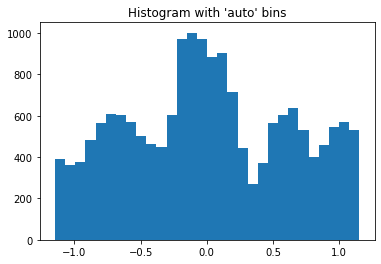

In [9]:
import matplotlib.pyplot as plt

a = lidar_data.copy()
a = a[:,6]
a[a>np.pi] = a[a > np.pi] - np.pi*2
_ = plt.hist(a, bins='auto')  # arguments are passed to np.histogram

plt.title("Histogram with 'auto' bins")
plt.show()

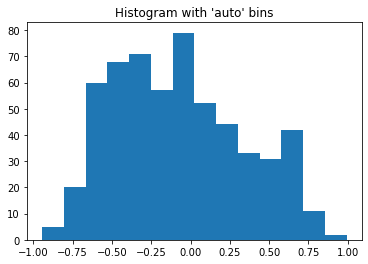

In [10]:
import matplotlib.pyplot as plt

a = radar_data.copy()
#a[a>3] = a[a > 3] - np.pi*2
a = a[:,1]
_ = plt.hist(a, bins='auto')  # arguments are passed to np.histogram

plt.title("Histogram with 'auto' bins")
plt.show()

In [38]:
def ConpensateLayerAngle(pcl,index,sensor_height):
    
    offset=0
    if(index%2==0):
        offset = np.deg2rad(.6)

    x = pcl[:,0] * np.cos(pcl[:,1]+offset) * np.cos(pcl[:,2])
    y = pcl[:,0] * np.cos(pcl[:,1]+offset) * np.sin(pcl[:,2])
    z = pcl[:,0] * np.sin(pcl[:,1]+offset) + sensor_height
    
    pcl[:,0] = x
    pcl[:,1] = y
    pcl[:,2] = z
    
    return pcl

def ProjectDataToImage(lidar_data, image_data, calib, sample_number=0):
    pts = ConpensateLayerAngle(lidar_data.copy(),sample_number,0.42)[:,:3]
    pts[:,[0, 1, 2]] = pts[:,[1, 0, 2]] # Swap the order
    pts[:,0]*=-1 # Left is positive

    imgpts, _ = cv2.projectPoints(np.array(pts), 
                                  calib['extrinsic']['rotation_vector'], 
                                  calib['extrinsic']['translation_vector'],
                                  calib['intrinsic']['camera_matrix'],
                                  calib['intrinsic']['distortion_coefficients'])
    imgpts=imgpts.squeeze(1).astype('int')
    
    (h,w,d) = np.shape(image_data);

    imgpts[:,0] = imgpts[:,0] / (1920 / w)
    imgpts[:,1] = imgpts[:,1] / (1080 / h)

    # Keep only points inside the image size
    idx = np.where( (imgpts[:,0]>=0) & (imgpts[:,0]<image.shape[1]) & (imgpts[:,1]>=0) & (imgpts[:,1]<image.shape[0]))[0]
    return imgpts[idx,0], imgpts[idx,1], idx

def u8Toi8(data):
    C = data.copy()
    C[C>127] = 127-C[C>127];
    return C

def PlotLidarRadarImage(lidar_data, radar_data, image_data, calib, sample_number, ax=plt):
    lx, ly, _ = ProjectDataToImage(lidar_data[:,[4,5,6]], image_data, calib, sample_number)
    
    rx, ry, idx = ProjectDataToImage(radar_data[:,[0,2,1]], image_data, calib)
    doppled_data = u8Toi8(radar_data[idx,4])/256;
    d = doppled_data
    C = np.zeros((np.shape(idx)[0],4))
    C[d > 0,0] = d[d > 0]*2
    C[d < 0,1] = -d[d < 0]*2
    C[:,3] = 1

    ax.scatter(lx,ly,color='b', alpha=.1)
    ax.scatter(rx,ry, c=C)

In [73]:
from datetime import datetime
n = datetime.now()
folder = n.isoformat().replace(":", "-") + '/'
!mkdir {folder}

sample_number = 0

In [81]:
%matplotlib inline
draw = False
save = True
for sample_number in range(sample_number, dataset.__len__()):
    data = dataset.__getitem__(sample_number)

    image_data = data[0]
    radarfft_data = data[1]
    radar_data = data[2]
    lidar_data = data[3]
    boxes_data = data[5]
    
    fig, ax = plt.subplots(figsize=(10,10))
    ax.imshow(image_data)
    
    PlotLidarRadarImage(lidar_data, radar_data, image_data, calib, sample_number, ax)
    
    for box in boxes_data:
        if(box[0]==-1):
            break # -1 means no object
        rect = Rectangle(box[:2]/2,(box[2]-box[0])/2,(box[3]-box[1])/2,linewidth=3, edgecolor='g', facecolor='none')
        ax.add_patch(rect)
    
    plt.legend(["Lidar", "Radar", "Labels"])

    try:
        if save:
            print(file_name)
            file_name = folder + str(sample_number) + '.png'
            plt.savefig(file_name)
            clear_output(wait=True)
        if draw:
            display(plt.gcf())
            clear_output(wait=True)
            plt.pause(0.001)
        plt.close(fig)
        
    except KeyboardInterrupt:
        break

2022-02-04T07-59-49.805019/8250.png


In [82]:
!ffmpeg -y -framerate 15 -pattern_type glob -i "{folder}*.png" -vcodec libx264 -crf 25 -pix_fmt yuv420p out.mp4

ffmpeg version 4.2.4-1ubuntu0.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.3.0-10ubuntu2)
  configuration: --prefix=/usr --extra-version=1ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-l

# Laser Point Cloud

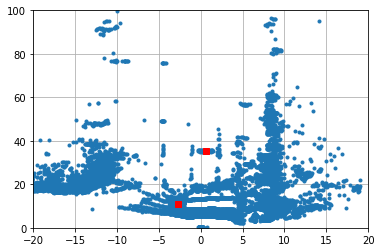

In [11]:
laser_pc = data[3]

plt.plot(-laser_pc[:,1],laser_pc[:,0],'.')
for box in boxes:
    if(box[0]==-1):
        break # -1 means no object
    plt.plot(box[4],box[5],'rs')
plt.xlim(-20,20)
plt.ylim(0,100)
plt.grid()

# Radar Point Cloud

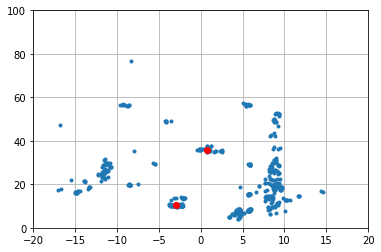

In [12]:
radar_pc = data[2]

plt.plot(-radar_pc[:,6],radar_pc[:,5],'.')
for box in boxes:
    if(box[0]==-1):
        break # -1 means no object
    plt.plot(box[7],box[8],'ro')
plt.xlim(-20,20)
plt.ylim(0,100)
plt.grid()

# Radar FFT spectrums

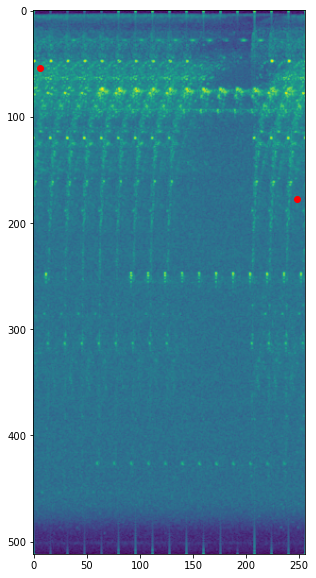

In [13]:
radar_FFT = data[1]
radar_FFT = radar_FFT[...,::2]+1j*radar_FFT[...,1::2]
power_spectrum = np.sum(np.abs(radar_FFT),axis=2)

plt.figure(figsize=(10,10))
plt.imshow(np.log10(power_spectrum))

for box in boxes:
    if(box[0]==-1):
        break # -1 means no object
    Range = box[9] * 512/103 # 512 range bins for 103m
    Azimuth = box[10]
    Doppler = box[11]
    plt.plot(Doppler,Range,'ro')

# Segmentation map

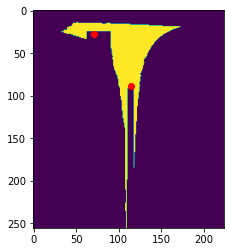

In [14]:
segmap = data[4]
plt.imshow(segmap) # In polar coordinnates
# Range resolution divided by 2
# Azimuth angle crop to 448 and resolution divided by 2
for box in boxes:
    if(box[0]==-1):
        break # -1 means no object
    Range = box[9]*512/103/2
    Azimuth = -box[10]/0.4

    plt.plot(segmap.shape[1]/2+Azimuth ,Range,'ro')

# Pytorch Loader

In [15]:
# Loader split the dataset in Train, Validation, and Test set based on sequences, 
# that is to say samples from a sequence can not be mixed between sets

In [16]:
train_loader, val_loader, test_loader = CreateDataLoaders(dataset)
print('Batch size:',[train_loader.batch_size, val_loader.batch_size,test_loader.batch_size])
print('train_loader:',len(train_loader))
print('val_loader:',len(val_loader))
print('test_loader:',len(test_loader))

Batch size: [4, 4, 4]
train_loader: 1558
val_loader: 247
test_loader: 259
